# Решение DS Хакатона от МКБ by Дорофеева Анастасия

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

### Выгружаем тренировочные данные, на которых будем обучать модель, и тестовые, которых мы собираемся обучить по полученным прогнозам.

In [2]:
train = pd.read_csv('D:/Новая папка/Кейс МКБ/train_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')
display(train)

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,07APR2019:00:00:00,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,...,382.0,381.0,45954226.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
17887,17888,838,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,193.0,184.0,134417510.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
17888,17889,10537,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17889,17890,1751,08APR2019:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Немного посмотрим на описательную статистику

In [3]:
display(train.describe().T)
train.isna().sum()
train = train.fillna(0)
train = train.loc[:, (train != 0).any(axis=0)] #удаляем нулевые столбцы
corl = train.corrwith(train["TARGET"])
display(corl)
# to_dr = corl.index[np.where(corl < 0)]
# to_dr
# tr = train.copy().drop(columns = to_dr.tolist())
# tr

,count,mean,std,min,25%,50%,75%,max
id_contract,17891.0,8.946000e+03,5.164831e+03,1.0,4473.5,8946.0,13418.5,1.789100e+04
id_client,17891.0,6.630653e+03,3.659133e+03,1.0,3452.0,6560.0,10080.0,1.273500e+04
IP_flag,17891.0,1.956291e-01,3.966953e-01,0.0,0.0,0.0,0.0,1.000000e+00
TARGET,17891.0,4.130010e-01,4.923868e-01,0.0,0.0,0.0,1.0,1.000000e+00
F1100,6936.0,3.184582e+09,3.062184e+10,-182000.0,433500.0,4308000.0,66616500.0,1.250774e+12
...,...,...,...,...,...,...,...,...
SUM_95_EVER,6784.0,2.544790e+08,1.140965e+09,0.0,4296130.5,18657065.5,93590967.0,3.813102e+10
FLAG_DISQUALIFICATION,5.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
COUNT_CHANGE_YEAR,239.0,1.502092e+00,1.511509e+00,1.0,1.0,1.0,2.0,1.300000e+01
COUNT_CHANGE_EVER,1509.0,2.325381e+00,2.316937e+00,1.0,1.0,2.0,2.0,2.500000e+01


id_contract             -0.004478
id_client                0.034947
IP_flag                 -0.066822
TARGET                   1.000000
F1100                   -0.053967
                           ...   
SUM_95_EVER              0.062488
FLAG_DISQUALIFICATION    0.019933
COUNT_CHANGE_YEAR        0.034597
COUNT_CHANGE_EVER       -0.055522
AGE                     -0.030479
Length: 112, dtype: float64

### Некоторые столбцы нам слабо помогут с пронозом, а будут толкько мешать своей не очень влияющей на исход информацией => уберем их из нашей выборки.

In [4]:
# train = train.drop(columns=['id_contract','id_client','F1530', 'SEX_NAME','OKVED_CODE','DATEFIRSTREG', 'OKATO_REGIONCODE','OKATO_FED','OKTMO_CODE','OKTMO_FED','TELEPHONECOUNT','MANAGERCOUNTINCOUNTRY','MANAGERCOUNTINREGION','MANAGERINNCOUNT','SIGN_DATE','IP_flag','BIRTHDATE','AGE', 'CITIZENSHIP_NAME',  'TAXREG_REGDATE','TAXREGPAY_REGDATE'])
train = train.drop(columns = ['id_contract','id_client','F1530','SIGN_DATE','TAXREG_REGDATE','TAXREGPAY_REGDATE','DATEFIRSTREG','BIRTHDATE','SEX_NAME',
 'CITIZENSHIP_NAME', 'OKVED_CODE'])
train
# tr = tr.drop(columns=['SIGN_DATE','id_client', 'SEX_NAME','OKVED_CODE','DATEFIRSTREG','OKATO_FED','OKTMO_FED','MANAGERCOUNTINREGION','MANAGERINNCOUNT','BIRTHDATE', 'CITIZENSHIP_NAME',  'TAXREG_REGDATE','TAXREGPAY_REGDATE'])

,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,...,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE
0,0,0,1.298961e+09,2154000.0,1.125573e+09,0.0,150010000.0,0.0,21224000.0,1.048287e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,7.337400e+07,0.0,7.337400e+07,0.0,0.0,0.0,0.0,2.161000e+07,...,4209963.0,169.0,0.0,169.0,168.0,18351739.0,0.0,0.0,1.0,0.0
3,0,0,1.937488e+09,122828000.0,6.103280e+08,0.0,809426000.0,356828000.0,38078000.0,5.786965e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,0,0,5.404500e+07,0.0,5.404500e+07,0.0,0.0,0.0,0.0,2.810200e+07,...,3939809.0,429.0,3.0,382.0,381.0,45954226.0,0.0,0.0,1.0,0.0
17887,0,0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,...,35569661.0,240.0,6.0,193.0,184.0,134417510.0,0.0,0.0,5.0,0.0
17888,0,0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,3.098000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17889,0,1,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2.559900e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# nen = train.select_dtypes(exclude=["number","bool_"]).columns.tolist() #проверяем на наличие категориальных столбцов во всех данных
# display(nen)
# # #нужно заполнить пропуски в данных
# # display(train.OKFS_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
# tr.OKFS_GROUP.replace(0, 'Не известно', inplace=True)

# # display(train.OKOPF_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
# tr.OKOPF_GROUP.replace(0, 'Не известно', inplace=True)

# # display(train.OKOGU_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
# tr.OKOGU_GROUP.replace(0, 'Не известно', inplace=True)


# # display(train.WORKERSRANGE.value_counts()) #распределение нормальное, поменяем на '0 .. 0'
# tr.WORKERSRANGE.replace(0, '0 .. 0', inplace=True)


### У нас есть в категориальных данных строки, где стоят просто нули. Проанализируем и заполним так называемые пропуски.

In [6]:
nn = train.select_dtypes(exclude=["number","bool_"]).columns.tolist() #проверяем на наличие категориальных столбцов во всех данных
display(nn)
# # #нужно заполнить пропуски в данных
# # display(train.OKFS_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
# train.OKFS_GROUP.replace(0, 'Не известно', inplace=True)

# # display(train.OKOPF_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
# train.OKOPF_GROUP.replace(0, 'Не известно', inplace=True)

# # display(train.OKOGU_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
# train.OKOGU_GROUP.replace(0, 'Не известно', inplace=True)


# # display(train.WORKERSRANGE.value_counts()) #распределение нормальное, поменяем на '0 .. 0'
train.WORKERSRANGE.replace(0, '0 .. 0', inplace=True)

for i in range(3):
    train[nn[i]].replace(0, 'Не известно', inplace=True)
    



['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

In [7]:
# display(train[nn[4]].value_counts()) 

### Посмотрим на соотношение невыполнение - '1' и выполнение - '0' контарктов

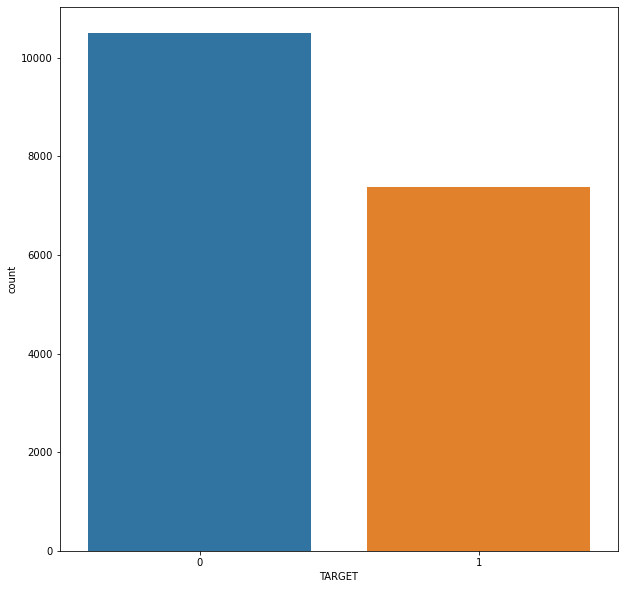

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(data = train, x = 'TARGET');

### Делим на категориальные и числовые фичи, выбираем data и target

In [9]:
cat_features = train.select_dtypes(exclude=["number","bool_"]).columns.tolist()
num_features = train.drop(columns = 'TARGET').select_dtypes(exclude=['object_']).columns.tolist()


data = train.drop(columns = 'TARGET')
target = train.TARGET
target

0        0
1        0
2        0
3        0
4        0
        ..
17886    0
17887    0
17888    0
17889    1
17890    0
Name: TARGET, Length: 17891, dtype: int64

In [10]:
cat_features

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

In [25]:
# cat_features_0 = tr.select_dtypes(exclude=["number","bool_"]).columns.tolist()
# num_features_0 = tr.drop(columns = 'TARGET').select_dtypes(exclude=['object_']).columns.tolist()

# data_0 = tr.drop(columns = 'TARGET')
# target_0 = tr.TARGET
# target_0
# data_0

In [26]:
print('Процент невыполнения контрактов: {:.1f}%'.format(np.mean(target)*100))

Процент невыполнения контрактов: 41.3%


## Построение модели

### Разделим тренировочный набор на 30% тестовый, 70% тренировчоный.

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold  
from sklearn.neighbors import KNeighborsClassifier 


X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, 
                                                    shuffle=True, stratify= target, random_state=1)

In [28]:
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold  
# from sklearn.neighbors import KNeighborsClassifier 


# X_train, X_test, y_train, y_test = train_test_split(data_0, target_0, test_size=0.3, 
#                                                     shuffle=True, stratify= target_0, random_state=1)

### Проведем перемасштабирование и форматирование категориальных переменных

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer


CT = ColumnTransformer([
        ("num", RobustScaler(with_centering=False), num_features),
        ("cat", OneHotEncoder(sparse=False), cat_features),
        ])

res_ct = CT.fit_transform(X_train)
res_ct

# display(pd.DataFrame(res_ct))

X_train_enc = pd.DataFrame(res_ct, columns = CT.get_feature_names_out()) # преобразовали тренировочный набор
X_test_enc = pd.DataFrame(CT.transform(X_test), columns = CT.get_feature_names_out()) # преобразовали внутренний тест (только transform!)

X_test_enc

,num__IP_flag,num__F1100,num__F1110,num__F1150,num__F1160,num__F1170,num__F1180,num__F1190,num__F1200,num__F1210,...,cat__WORKERSRANGE_101 .. 150,cat__WORKERSRANGE_11 .. 15,cat__WORKERSRANGE_151 .. 200,cat__WORKERSRANGE_16 .. 50,cat__WORKERSRANGE_201 .. 250,cat__WORKERSRANGE_251 .. 500,cat__WORKERSRANGE_5000 и более,cat__WORKERSRANGE_501 .. 1000,cat__WORKERSRANGE_51 .. 100,cat__WORKERSRANGE_6 .. 10
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.198566,0.453838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,32.855105,0.0,31.283135,0.0,0.0,55000.0,185000.0,3.201493,14.015553,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,75.938438,0.0,66.103038,0.0,0.0,26090000.0,0.0,13.894992,50.611366,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,0.0,88.331832,0.0,100.659621,0.0,0.0,1258000.0,2101000.0,3.075940,3.574078,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5364,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.001241,0.002393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5365,0.0,0.959459,0.0,1.125495,0.0,0.0,0.0,0.0,0.708839,5.619143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5366,0.0,125.509760,0.0,85.401145,0.0,0.0,70206000.0,0.0,1.911814,3.448056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Модель случайного леса

In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
rfc = RandomForestClassifier(n_jobs=-1,random_state=1)
rfc.fit(X_train_enc,y_train)
display(rfc.score(X_train_enc,y_train))
rfc.score(X_test_enc, y_test)

0.986185418829354

0.8990312965722802

### Модель градиентного бустинга

In [31]:
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train_enc,y_train)
display(gb.score(X_train_enc,y_train))
gb.score(X_test_enc,y_test)

0.8590593308312705

0.853204172876304

###  С помощью графиков проанализируем лучшие параметры для моделей

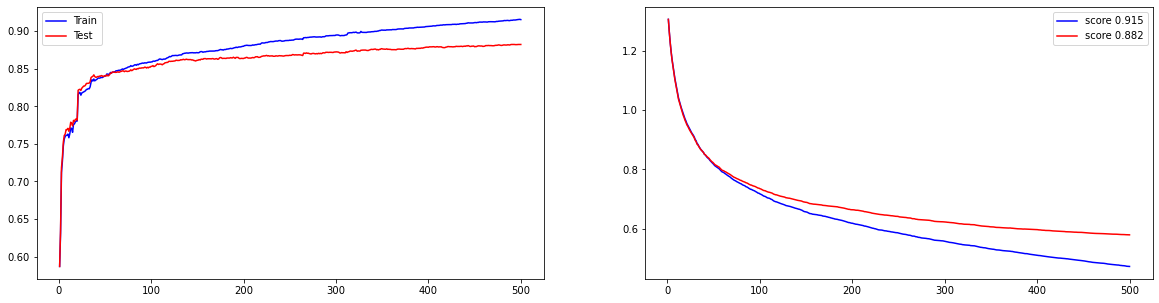

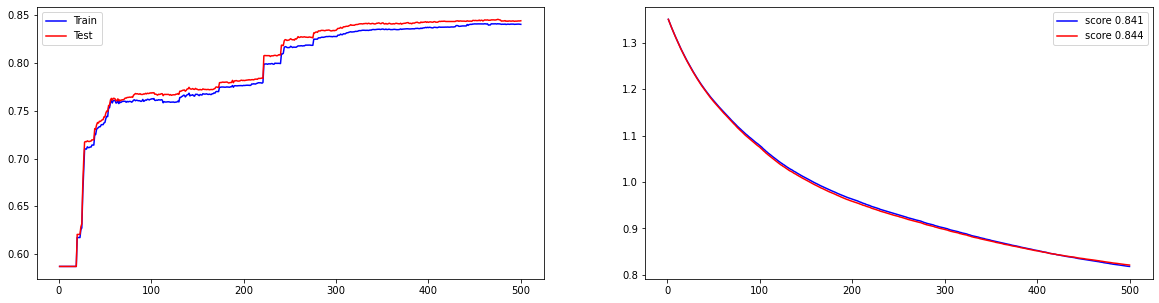

In [32]:
# Тут для бустинга
from sklearn.metrics import accuracy_score
def plot_learnig_tree(estimator, X_train, X_test, y_train, y_test):  
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    n_estimators = estimator.n_estimators_
    zero = np.zeros(n_estimators, dtype=np.float64)
    color_one = 'blue'
    color_two = 'red'
    
    train_score = zero
    for i, y_pred_train in enumerate(estimator.staged_predict(X_train)):
        train_score[i] = accuracy_score(y_train, y_pred_train)
    ax1.plot(
        (np.arange(train_score.shape[0]) + 1),
        train_score,
        "-",
        color=color_one,
        label='Train',
        )
        
    test_score = zero
    for i, y_pred_test in enumerate(estimator.staged_predict(X_test)):
        train_score[i] = accuracy_score(y_test, y_pred_test)    
    ax1.plot(
        (np.arange(test_score.shape[0]) + 1),
        train_score,
        "-",
        color = color_two,
        label='Test',
        )
    ax1.legend(loc='best')


    train_deviance = zero
    for i, y_pred_train in enumerate(estimator.staged_decision_function(X_train)):
        train_deviance[i] = estimator.loss_(y_train, y_pred_train)
        
    ax2.plot(
        (np.arange(train_deviance.shape[0]) + 1),
        train_deviance,
        '-',
        color=color_one,
        label="score "+str(round(estimator.score(X_train, y_train),3))
    )

    test_deviance = zero
    for i, y_pred_test in enumerate(estimator.staged_decision_function(X_test)):
        test_deviance[i] = estimator.loss_(y_test, y_pred_test)
        
    ax2.plot(
        (np.arange(test_deviance.shape[0]) + 1),
        test_deviance,
        '-',
        color=color_two,
        label="score "+str(round(estimator.score(X_test, y_test),3))
    )
    ax2.legend(loc='best')
    

clf = GradientBoostingClassifier(n_estimators=500,random_state=1)
clf.fit(X_train_enc, y_train)
plot_learnig_tree(clf, X_train_enc, X_test_enc, y_train, y_test)

clf = GradientBoostingClassifier(n_estimators=500,random_state=1, learning_rate = 0.01)
clf.fit(X_train_enc, y_train)
plot_learnig_tree(clf, X_train_enc, X_test_enc, y_train, y_test)

In [33]:
# Явное улучшение скоров при выборе лучших параметров
gb = GradientBoostingClassifier(subsample=1,n_estimators=300, min_samples_split=50,max_features='auto',learning_rate=0.2, random_state = 1)
gb.fit(X_train_enc,y_train)

print(f'Результат на тренировочном наборе: {round(gb.score(X_train_enc,y_train),4)}')
print(f'Результат на тестовом наборе: {round(gb.score(X_test_enc,y_test),4)}')

Результат на тренировочном наборе: 0.9237
Результат на тестовом наборе: 0.8856


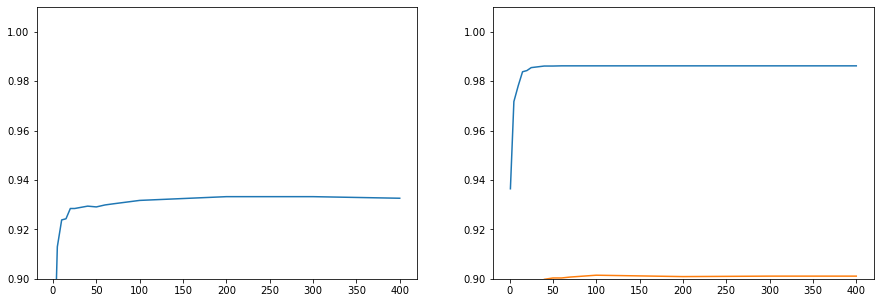

In [34]:
# Тут для случайного леса
sc_train1 =[]
sc_test1 = []
sc_train2 =[]
sc_test2 = []
n_estimators = [1, 5, 10, 15, 20, 25, 40, 50, 60, 70, 100, 200, 300, 400]
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators= n , max_features='sqrt', min_samples_leaf = 5, random_state=1)
    rf.fit(X_train_enc, y_train)
    sc_train_n = rf.score(X_train_enc, y_train)
    sc_test_n = rf.score(X_test_enc, y_test)
    sc_train1.append(sc_train_n)
    sc_test1.append(sc_test_n)

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators= n , max_features=10, random_state=1)
    rf.fit(X_train_enc, y_train)
    sc_train_n = rf.score(X_train_enc, y_train)
    sc_test_n = rf.score(X_test_enc, y_test)
    sc_train2.append(sc_train_n)
    sc_test2.append(sc_test_n)    
    
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(n_estimators,sc_train1)
ax1.plot(n_estimators,sc_test1)
ax1.set_ylim(0.9, 1.01)
ax2.plot(n_estimators,sc_train2)
ax2.plot(n_estimators,sc_test2)
ax2.set_ylim(0.9, 1.01);

In [35]:
# Score практически не изменился, лишь какие-то тысячные доли на тестовом
rfc = RandomForestClassifier(n_estimators=400,max_features=10,n_jobs=-1, random_state = 1)
rfc.fit(X_train_enc,y_train)
print(f'Результат на тренировочном наборе: {round(rfc.score(X_train_enc,y_train),4)}')
print(f'Результат на тестовом наборе: {round(rfc.score(X_test_enc,y_test),4)}')

Результат на тренировочном наборе: 0.9862
Результат на тестовом наборе: 0.9011


### Посмотрим на важность фичей, которые мы получили 

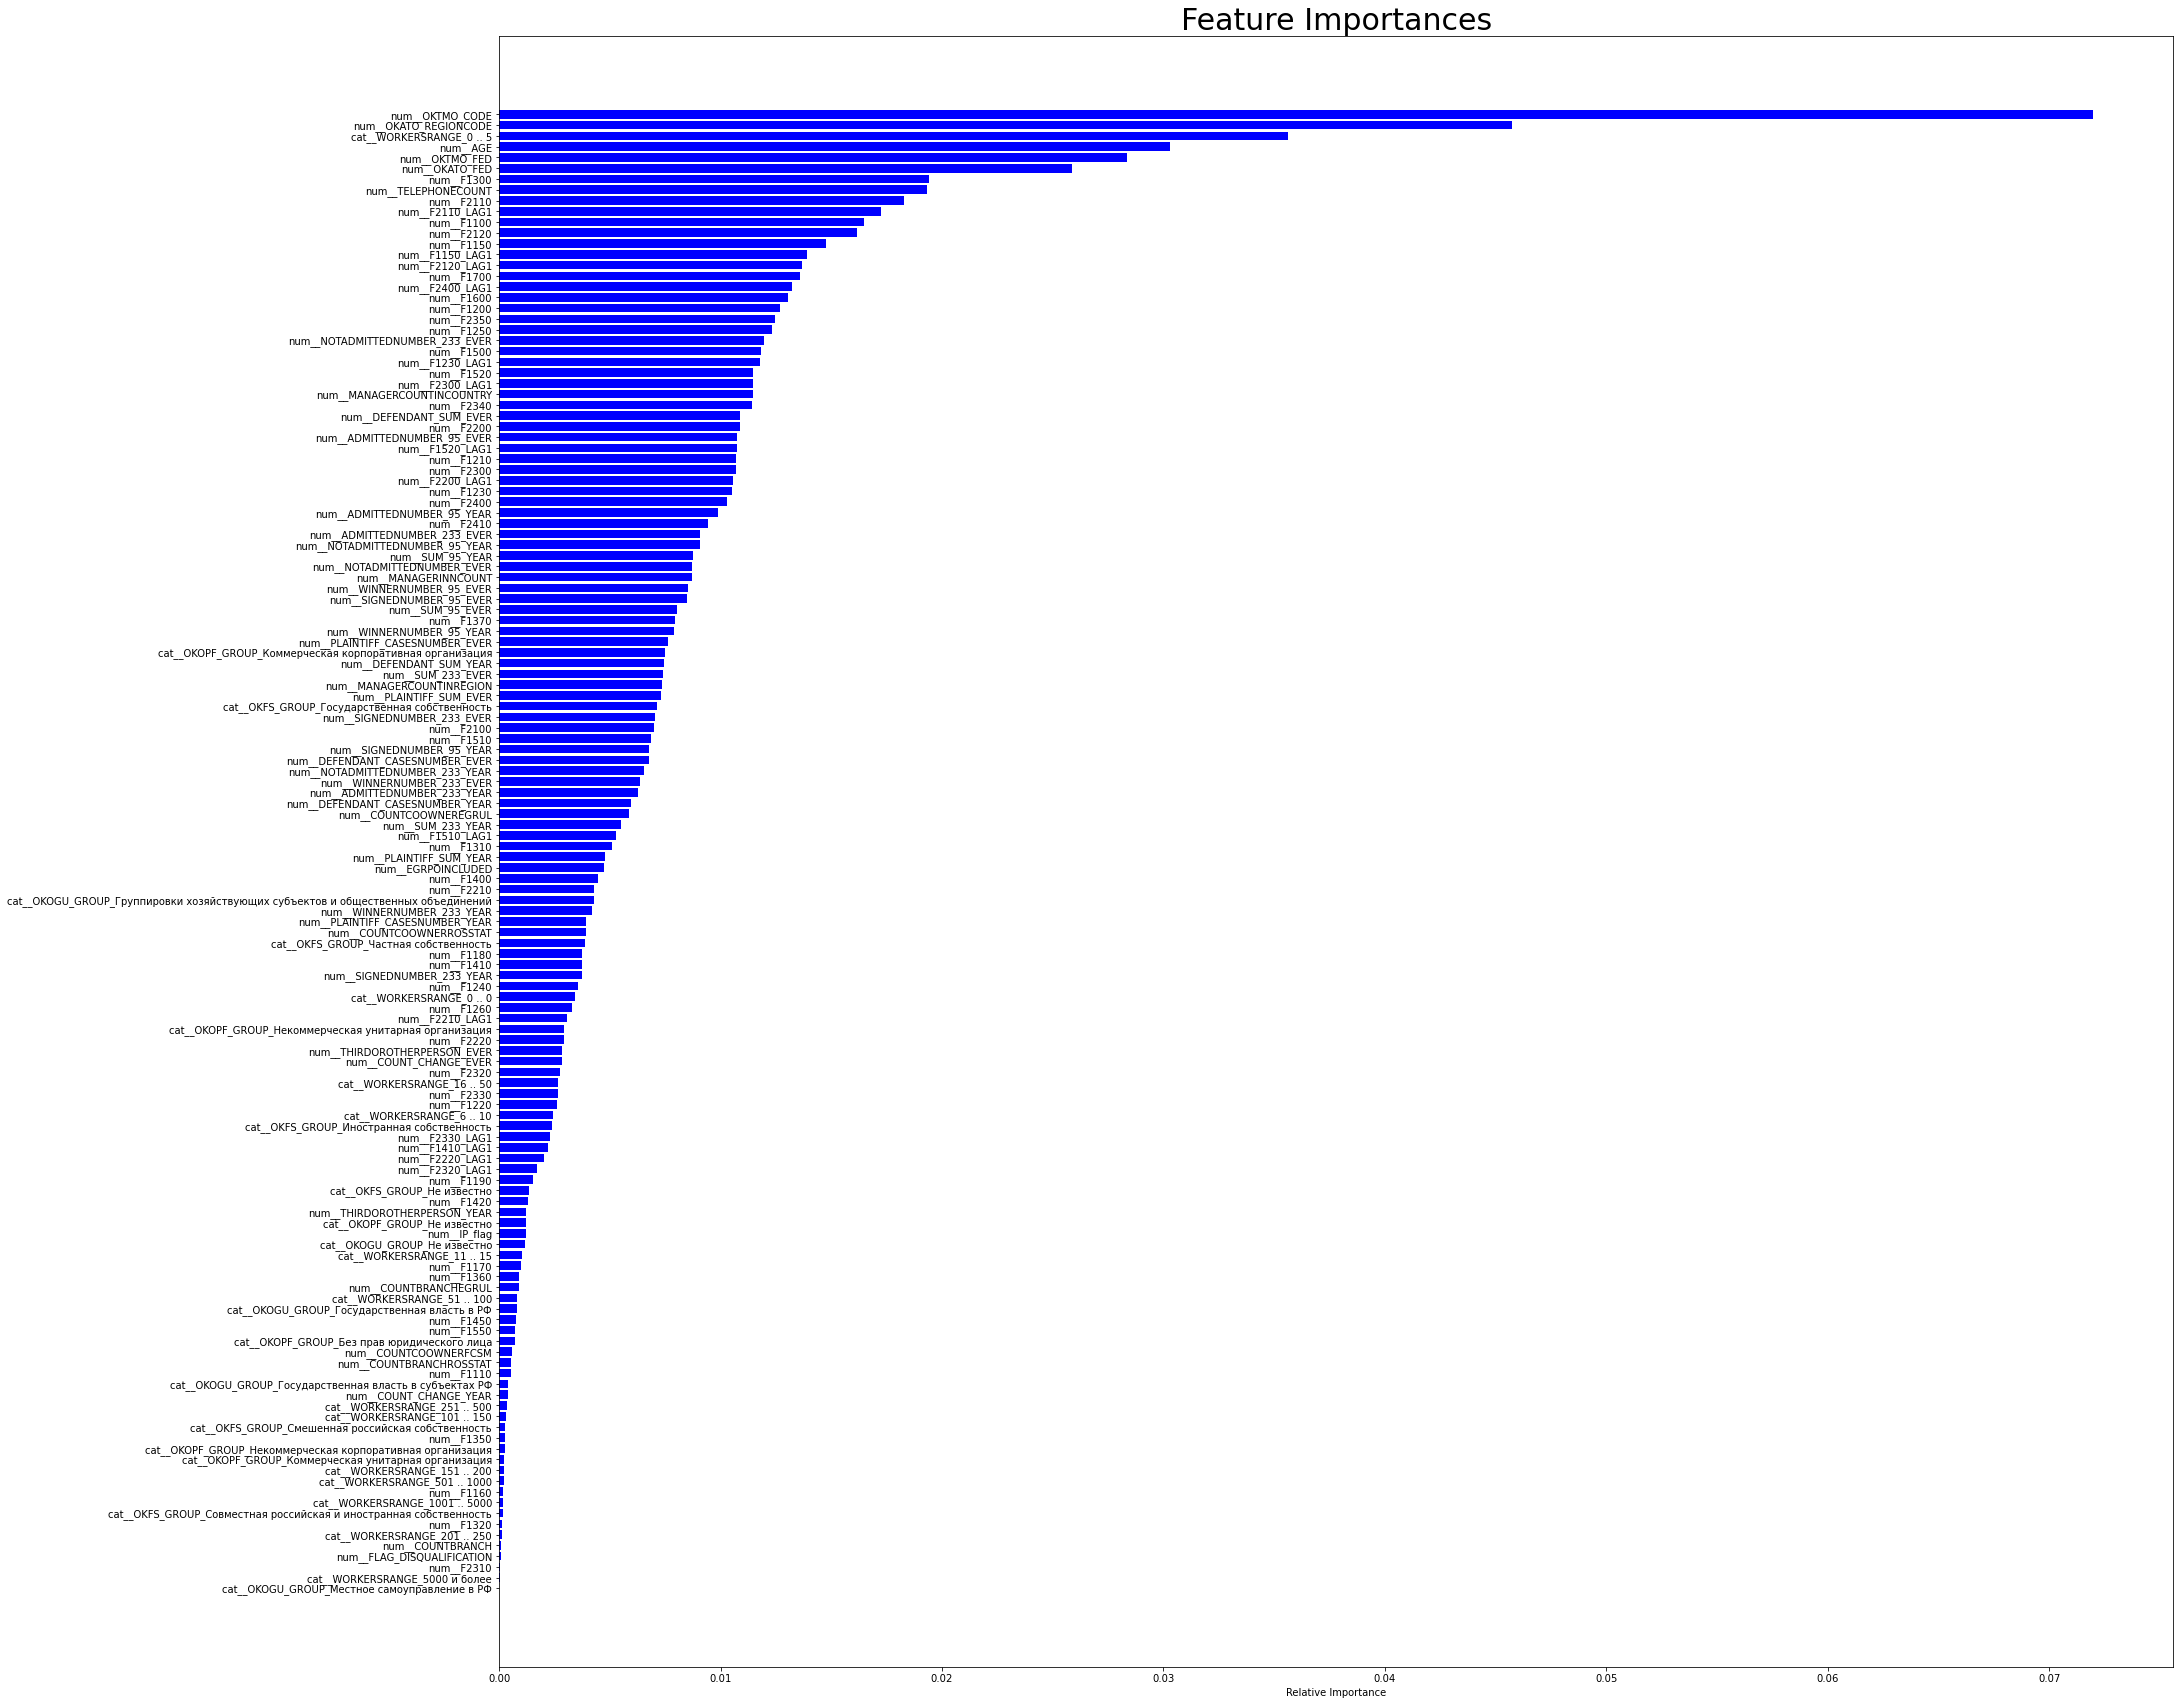

In [36]:
features = CT.get_feature_names_out()
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(30,30))
plt.title('Feature Importances',size=30)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Построим confusion_matrix для бустинга и леса

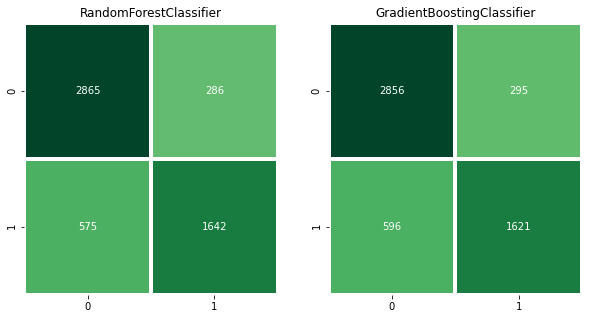

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

y_pred_rfc = rfc.predict(X_test_enc)

sns.heatmap(confusion_matrix(y_test,y_pred_rfc),annot=True, fmt='g', cbar=None,cmap="YlGn",linewidths=3, center=0,ax=ax1);
ax1.set_title('RandomForestClassifier')

y_pred_gb = gb.predict(X_test_enc)
ax2.set_title('GradientBoostingClassifier')
sns.heatmap(confusion_matrix(y_test,y_pred_gb),annot=True, fmt='g', cbar=None,cmap="YlGn",linewidths=3, center=0,ax=ax2);


### Посмотрим аналитический отчет по предсказаниям на тренировочном

In [21]:
print(classification_report(y_test,y_pred_rfc))
print(classification_report(y_test,y_pred_gb))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3151
           1       0.85      0.74      0.79      2217

    accuracy                           0.84      5368
   macro avg       0.84      0.82      0.83      5368
weighted avg       0.84      0.84      0.84      5368

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3151
           1       0.85      0.73      0.78      2217

    accuracy                           0.83      5368
   macro avg       0.84      0.82      0.82      5368
weighted avg       0.84      0.83      0.83      5368



### Строим кривые ROC

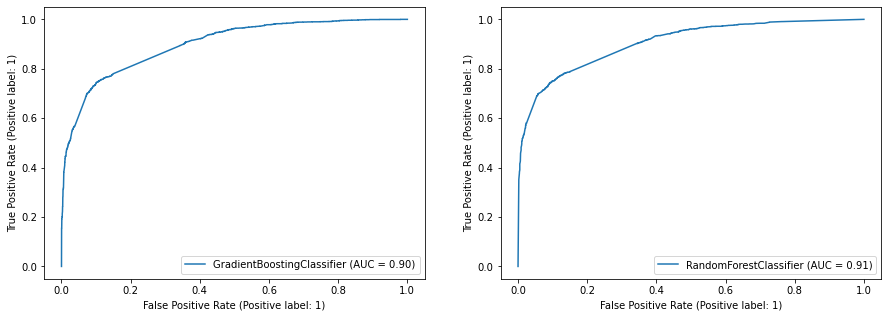

In [22]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_estimator(gb, X_test_enc, y_test,ax=ax1);
RocCurveDisplay.from_estimator(rfc, X_test_enc, y_test,ax=ax2);

### Проверяем тестовые данные

In [26]:
test = pd.read_csv('D:/Новая папка/Кейс МКБ/test_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';') 
test_1 = pd.read_csv('D:/Новая папка/Кейс МКБ/test_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')
test = test.fillna(0)
test = test.loc[:, (test != 0).any(axis=0)]
test = test.drop(columns=['id_contract','id_client','F1530', 'SEX_NAME','OKVED_CODE','DATEFIRSTREG', 'OKATO_REGIONCODE','OKATO_FED','OKTMO_CODE','OKTMO_FED','TELEPHONECOUNT','MANAGERCOUNTINCOUNTRY','MANAGERCOUNTINREGION','MANAGERINNCOUNT','SIGN_DATE','IP_flag','BIRTHDATE','AGE', 'CITIZENSHIP_NAME',  'TAXREG_REGDATE',
 'TAXREGPAY_REGDATE'])
# test = test[tr.drop(columns = 'TARGET').columns.tolist()]

test_1 = test_1.fillna(0)
test_1 = test_1.loc[:, (test_1 != 0).any(axis=0)]
test_1 = test_1.drop(columns=['id_client', 'SEX_NAME','OKVED_CODE','DATEFIRSTREG', 'OKATO_REGIONCODE','OKATO_FED','OKTMO_CODE','OKTMO_FED','TELEPHONECOUNT','MANAGERCOUNTINCOUNTRY','MANAGERCOUNTINREGION','MANAGERINNCOUNT','SIGN_DATE','IP_flag','BIRTHDATE','AGE', 'CITIZENSHIP_NAME',  'TAXREG_REGDATE',
 'TAXREGPAY_REGDATE'])
test #отсутствует TARGET - сейчас можем только создать предсказания до того, когда будет подгуржен полный набор


,F1320,F2410,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,WORKERSRANGE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,PLAINTIFF_SUM_EVER,...,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR
0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
1,0.0,600000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,16 .. 50,2.0,0.0,0.0,4726558.0,...,857.0,767.0,138194657.0,10240.0,69.0,7439.0,7100.0,1.187411e+09,0.0,0.0
2,0.0,371000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,16 .. 50,10.0,2272145.0,2.0,27542049.0,...,7.0,7.0,2375210.0,764.0,50.0,362.0,344.0,9.836260e+07,0.0,1.0
3,0.0,94000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
4,0.0,18000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7325,0.0,15000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
7326,0.0,0.0,Частная собственность,Без прав юридического лица,Группировки хозяйствующих субъектов и обществе...,101 .. 150,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
7327,0.0,98000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,0.0,0.0,0.0,0.0,...,11.0,11.0,2721018.0,28.0,1.0,17.0,17.0,3.012122e+06,0.0,0.0
7328,0.0,21000.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,0.0,0.0,0.0,0.0,...,1.0,1.0,2000000.0,2.0,1.0,2.0,2.0,4.000000e+06,0.0,0.0


### Предобработка данных

In [27]:
mm = test.select_dtypes(exclude=["number","bool_"]).columns.tolist() #проверяем на наличие категориальных столбцов во всех данных
display(mm)
# #нужно заполнить пропуски в данных
# display(train.OKFS_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
test.OKFS_GROUP.replace(0, 'Не известно', inplace=True)

# display(train.OKOPF_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
test.OKOPF_GROUP.replace(0, 'Не известно', inplace=True)

# display(train.OKOGU_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
test.OKOGU_GROUP.replace(0, 'Не известно', inplace=True)


# display(train.WORKERSRANGE.value_counts()) #распределение нормальное, поменяем на '0 .. 0'
test.WORKERSRANGE.replace(0, '0 .. 0', inplace=True)



mm1 = test_1.select_dtypes(exclude=["number","bool_"]).columns.tolist() #проверяем на наличие категориальных столбцов во всех данных
display(mm1)
# #нужно заполнить пропуски в данных
# display(train.OKFS_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
test_1.OKFS_GROUP.replace(0, 'Не известно', inplace=True)

# display(train.OKOPF_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
test_1.OKOPF_GROUP.replace(0, 'Не известно', inplace=True)

# display(train.OKOGU_GROUP.value_counts()) #распределение нормальное, поменяем на 'Не известно'
test_1.OKOGU_GROUP.replace(0, 'Не известно', inplace=True)


# display(train.WORKERSRANGE.value_counts()) #распределение нормальное, поменяем на '0 .. 0'
test_1.WORKERSRANGE.replace(0, '0 .. 0', inplace=True)

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

### Преобразовываем нашу тестовую выборку

In [28]:
X_test_t = pd.DataFrame(CT.transform(test), columns = CT.get_feature_names_out()) 

### Строим предсказания

In [29]:
y_pred_gb = gb.predict(X_test_t) # предсказанные значения бустинг
y_pred_rfc = rfc.predict(X_test_t) # предсказанные значения лес

### Есть возможность по полученным предсказаниям оценить процент невыполнения контрактов

In [30]:
print('Процент невыполнения контрактов согласно модели градиентного бустинга: {:.1f}%'.format(np.mean(y_pred_gb)*100))
print('Процент невыполнения контрактов согласно модели случайного леса: {:.1f}%'.format(np.mean(y_pred_rfc)*100))

Процент невыполнения контрактов согласно модели градиентного бустинга: 29.2%
Процент невыполнения контрактов согласно модели случайного леса: 28.0%


In [31]:
# predict probabilities
pred_prob1 = gb.predict_proba(X_test_t)
pred_prob2 = rfc.predict_proba(X_test_t)
pred_prob1

array([[0.67896321, 0.32103679],
       [0.99538179, 0.00461821],
       [0.42551568, 0.57448432],
       ...,
       [0.42256578, 0.57743422],
       [0.52985375, 0.47014625],
       [0.94832304, 0.05167696]])

In [34]:
test_1['TARGET'] = gb.predict_proba(X_test_t)[:, 1]
test_1[['id_contract', 'TARGET']]
test_1[['id_contract', 'TARGET']].to_csv('submit_file.csv', sep=';', index=False)

In [33]:
#Тут результат лучше
test_1['TARGET'] = rfc.predict_proba(X_test_t)[:, 1]
test_1[['id_contract', 'TARGET']]
test_1[['id_contract', 'TARGET']].to_csv('submit_file.csv', sep=';', index=False)

In [67]:
from sklearn.metrics import roc_auc_score

# auc scores
# auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
# auc_score2 = roc_auc_score(y_test.TARGET, pred_prob2[:,1])

# print(auc_score1, auc_score2)

### Тут смотрим на score тестового набора, имеющего колонку с TARGET, нужно раскомментировать

In [ ]:
# print('Правильность на тестовом наборе модели градиентного бустинга: {:.3f}'.format(gb.score(X_test_t, test.TARGET)))
# print('Правильность на тестовом наборе модели случайного леса: {:.3f}'.format(rfc.score(X_test_t, test.TARGET)))


# print(classification_report(test.TARGET, y_pred_gb)) #Отчет для бустинга
# print(classification_report(test.TARGET, y_pred_rfc))#Отчет для леса

# print('Confusion matrix модели градиентного бустинга')
# matrix_1 = confusion_matrix(test.TARGET, y_pred_gb)
# fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5))
# ax = plt.subplot(1, 1, 1)
# sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");

# print('Confusion matrix модели случайного леса')
# matrix_2 = confusion_matrix(test.TARGET, y_pred_rfc)
# fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,5))
# ax = plt.subplot(1, 1, 1)
# sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");

### Кривые ROC Для 2-х моделей

In [ ]:
# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
# RocCurveDisplay.from_estimator(gb, X_test_t, test.TARGET,ax=ax1);
# RocCurveDisplay.from_estimator(rfc, X_test_t, test.TARGET,ax=ax2);